<a href="https://colab.research.google.com/github/bhanu1100/Signature-Forgery-Detection-with-Forger-Detection/blob/main/Signature_forgery_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.metrics import accuracy_score
import seaborn as sns
from shutil import copy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os

In [ ]:
Dataset_path = "/content/drive/MyDrive/dataset"
image_path = '/content/drive/MyDrive/testdata/dataset/forge/u10_foged (8).jpg'

In [ ]:
def loading_data(data_path = Dataset_path, test_size = 0.2, verbose = True, load_grayscale = True):
  forged_images_feature = []
  real_images_features = []
  labels = []
  features = []
  features_dictionary = {}
  mode = 'rgb'
  if load_grayscale:
    mode = 'grayscale'
  for folder in os.listdir(data_path):
    if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
            continue
    print(f"Searching {folder}")
    #extracting images from forged signatures folder
    for sub in os.listdir(data_path + "/" + folder + "/forge"):
      # Going through the forged signatures folder
      f = data_path + "/" + folder +"/forge/" + sub
      img = load_img(f,color_mode=mode, target_size=(150,150))
      # Collecting features from all images
      features.append(img_to_array(img))
      features_dictionary[sub] = (img, 0)
      forged_images_feature.append(img)
      if verbose:
        print(f"Adding {f} with label 0")
      # Assigning 0 to forged signature images
      labels.append(0)
    for sub in os.listdir(data_path + "/" + folder + "/real"):
      # Going through the real signatures folder
      f = data_path + "/" + folder + "/real/" + sub
      img = load_img(f,color_mode=mode, target_size=(150,150))
      features.append(img_to_array(img))
      features_dictionary[sub] = (img, 0)
      real_images_features.append(img)
      if verbose:
        print(f"Adding {f} with label 1")
      # Assigning 1 to real signature images
      labels.append(1)
  features = np.array(features)
  # We have two labels 0 and 1
  labels = np.array(labels)
  # Dividing the generated data into test and train
  x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
  # Seperating validation from train
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
  print("Data generated.")
  return features, labels, forged_images_feature, real_images_features, features_dictionary, x_train, x_test, y_train, y_test, x_val, y_val
features, labels,forged_images_feature, real_images_features, features_dictionary, x_train, x_test, y_train, y_test, x_val, y_val = loading_data(verbose=False, load_grayscale=False)


Searching dataset
Data generated.


In [ ]:
# Normallizing the data by dividing with 255(the max value it can have)
x_train /= 255.
x_val /= 255.
x_test /= 255.

In [ ]:
# Building a CNN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 16)        0

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
4/4 [==============================] - 9s 2s/step - loss: 0.8512 - acc: 0.5439 - val_loss: 0.7465 - val_acc: 0.3684
Epoch 2/5
4/4 [==============================] - 5s 1s/step - loss: 0.6945 - acc: 0.5263 - val_loss: 0.7025 - val_acc: 0.3947
Epoch 3/5
4/4 [==============================] - 6s 2s/step - loss: 0.6877 - acc: 0.5175 - val_loss: 0.6673 - val_acc: 0.6316
Epoch 4/5
4/4 [==============================] - 6s 1s/step - loss: 0.6838 - acc: 0.5088 - val_loss: 0.7149 - val_acc: 0.3684
Epoch 5/5
4/4 [==============================] - 9s 2s/step - loss: 0.6637 - acc: 0.6316 - val_loss: 0.6962 - val_acc: 0.5263


Since we were not able to achieve good accuracy with CNN alone we use the technique of TRANSFER LAYERS.

In [ ]:
# loading Inception
model2 = tf.keras.applications.InceptionV3(include_top=False, input_shape=(150,150,3))
# freezing layers
for layer in model2.layers:
    layer.trainable=False
# getting mixed7 layer
l = model2.get_layer("mixed7")

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Second model
x = tf.keras.layers.Flatten()(l.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
net = tf.keras.Model(model2.input, x)
net.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])
h2 = net.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
4/4 [==============================] - 15s 3s/step - loss: 8.1016 - acc: 0.3596 - val_loss: 2.1666 - val_acc: 0.6316
Epoch 2/5
4/4 [==============================] - 13s 3s/step - loss: 2.9409 - acc: 0.6667 - val_loss: 3.9975 - val_acc: 0.4474
Epoch 3/5
4/4 [==============================] - 13s 4s/step - loss: 0.7951 - acc: 0.7807 - val_loss: 1.6752 - val_acc: 0.6842
Epoch 4/5
4/4 [==============================] - 11s 3s/step - loss: 0.6305 - acc: 0.8333 - val_loss: 2.3117 - val_acc: 0.4474
Epoch 5/5
4/4 [==============================] - 10s 2s/step - loss: 0.4588 - acc: 0.8596 - val_loss: 0.8214 - val_acc: 0.7632


In [ ]:
# Testing our model
preds = net.predict(x_test)
pred_labels = []
# Threshold is 0.5
for p in preds:
    if p >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)
print ("Accuracy on test set: {}".format(accuracy_score(y_test, pred_labels)))

2/2 [==============================] - 3s 399ms/step
Accuracy on test set: 0.7894736842105263


In [ ]:
# In this function we are converting previously assigned labels to Names
def convert_label_to_text(label=0):

    return "Forged" if label == 0 else "Real"
# Preprocessing of the image to test
def load_and_preprocess_image(image_path, target_size=(150, 150), load_grayscale=False):
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    img = load_img(image_path, color_mode=mode, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array
# Predicting using the model
def classify_image_with_models(image_path, model, net):
    input_image = load_and_preprocess_image(image_path)

    prediction_model = model.predict(input_image)
    label_model = convert_label_to_text(np.round(prediction_model)[0][0])

    prediction_net = net.predict(input_image)
    label_net = convert_label_to_text(np.round(prediction_net)[0][0])

    return label_model, prediction_model, label_net, prediction_net

label_model, prediction_model, label_net, prediction_net = classify_image_with_models(image_path, model, net)

print(f"Prediction: {label_net}")

1/1 [==============================] - 0s 81ms/step
Prediction: Forged


##Who might have forged the signature?

Here we will try to predict who might have forged a signature if forged.

In [ ]:
# Importing required libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
# Path to the dataset
# Here we are using same images but with differrent arrangement of classes
# Since we have 10 users we get 10 classes
New_Dataset_path = '/content/drive/MyDrive/user_dataset'

In [ ]:
# Extracting of images from different classes
# Preprocessing the images
def load_data(Data_path=New_Dataset_path, test_size=0.2, verbose=True, load_grayscale=True):

    features = []
    features_dict = {}
    labels = []  # Labels from 0 to 9 for 10 classes
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"

    for folder in os.listdir(Data_path):
        if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
            continue

        print("Searching folder {}".format(folder))
        class_label = int(folder.split('_')[-1]) - 1
        for sub in os.listdir(os.path.join(Data_path, folder)):
            f = os.path.join(Data_path, folder, sub)
            img = load_img(f, color_mode=mode, target_size=(150, 150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, class_label)
            if verbose:
                print("Adding {} with label {}".format(f, class_label))
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)

    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

    print("Generated data.")
    return features, labels, x_train, x_test, y_train, y_test, x_val, y_val


def convert_label_to_text(label=0):
    class_names = ['user_0', 'user_1','user_2','user_3', 'user_4','user_5', 'user_6','user_7', 'user_8','user_9'  ]
    return class_names[label]

# Load data for 10 classes
features, labels, x_train, x_test, y_train, y_test, x_val, y_val = load_data(verbose=False, load_grayscale=False)

# Normalize inputs
x_train /= 255.
x_val /= 255.
x_test /= 255.


Searching folder user_0
Searching folder user_1
Searching folder user_2
Searching folder user_3
Searching folder user_4
Searching folder user_5
Searching folder user_6
Searching folder user_7
Searching folder user_8
Searching folder user_9
Generated data.


In [ ]:
image_size = (150, 150)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    New_Dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    New_Dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 80 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [ ]:
# Model building
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_generator, epochs=30,validation_data=validation_generator)

Epoch 1/30
3/3 [==============================] - 6s 2s/step - loss: 2.8331 - accuracy: 0.1125 - val_loss: 2.3175 - val_accuracy: 0.2000
Epoch 2/30
3/3 [==============================] - 5s 1s/step - loss: 2.3103 - accuracy: 0.1750 - val_loss: 2.2887 - val_accuracy: 0.1000
Epoch 3/30
3/3 [==============================] - 5s 1s/step - loss: 2.3069 - accuracy: 0.1000 - val_loss: 2.2732 - val_accuracy: 0.1000
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 2.2758 - accuracy: 0.0500 - val_loss: 2.2558 - val_accuracy: 0.1000
Epoch 5/30
3/3 [==============================] - 6s 1s/step - loss: 2.2460 - accuracy: 0.1000 - val_loss: 2.2135 - val_accuracy: 0.1000
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 2.1953 - accuracy: 0.1000 - val_loss: 2.1330 - val_accuracy: 0.1000
Epoch 7/30
3/3 [==============================] - 4s 1s/step - loss: 2.0999 - accuracy: 0.1125 - val_loss: 2.0492 - val_accuracy: 0.1000
Epoch 8/30
3/3 [=========================

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 224ms/step - loss: 1.6568 - accuracy: 0.6000
Test accuracy: 0.6000000238418579


In [ ]:
# Save the model
model.save('image_classification_CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


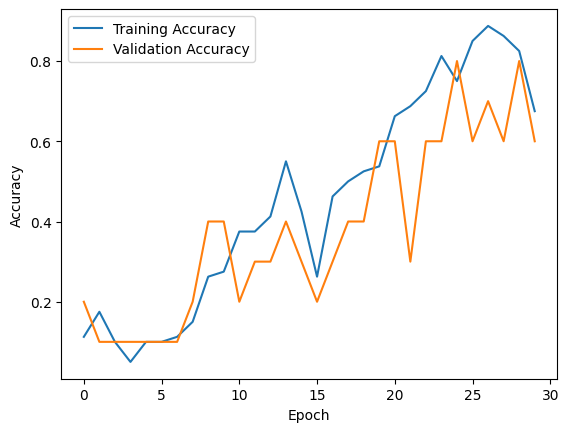

In [ ]:
#plotting the graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Additional model to improve accuracy

We can stop with the CNN model but since the accuracy is not high I've used the TRANSFER LAYERS technique here.

Which indeed gave better results.

In [ ]:
# loading Inception'
import tensorflow as tf
model2 = tf.keras.applications.InceptionV3(include_top=False, input_shape=(150,150,3))
# freezing layers
for layer in model2.layers:
    layer.trainable=False
# getting mixed7 layer
l = model2.get_layer("mixed7")
print ("mixed7 shape: {}".format(l.output_shape))

mixed7 shape: (None, 7, 7, 768)


In [ ]:
# Second model
x = tf.keras.layers.Flatten()(l.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
net = tf.keras.Model(model2.input, x)
net.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])
h2 = net.fit(train_generator, validation_data=(validation_generator), epochs=15)

Epoch 1/15
3/3 [==============================] - 17s 4s/step - loss: 3.2606 - acc: 0.8400 - val_loss: 4.2198 - val_acc: 0.9000
Epoch 2/15
3/3 [==============================] - 7s 3s/step - loss: 2.4509 - acc: 0.9000 - val_loss: 1.9160 - val_acc: 0.2600
Epoch 3/15
3/3 [==============================] - 6s 2s/step - loss: 1.4211 - acc: 0.6200 - val_loss: 1.3931 - val_acc: 0.9000
Epoch 4/15
3/3 [==============================] - 7s 2s/step - loss: 1.4799 - acc: 0.9000 - val_loss: 1.0048 - val_acc: 0.9000
Epoch 5/15
3/3 [==============================] - 6s 2s/step - loss: 1.0776 - acc: 0.8300 - val_loss: 1.0108 - val_acc: 0.6600
Epoch 6/15
3/3 [==============================] - 11s 4s/step - loss: 1.2007 - acc: 0.7400 - val_loss: 1.3528 - val_acc: 0.9000
Epoch 7/15
3/3 [==============================] - 7s 3s/step - loss: 1.4753 - acc: 0.9000 - val_loss: 1.3259 - val_acc: 0.9000
Epoch 8/15
3/3 [==============================] - 7s 2s/step - loss: 1.1317 - acc: 0.9000 - val_loss: 0.6850 

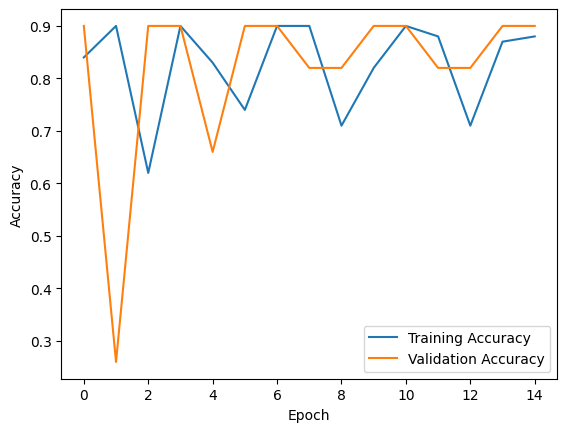

In [ ]:
# Plotting the graph
plt.plot(h2.history['acc'], label='Training Accuracy')
plt.plot(h2.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Here we are checking the prediction of the user who might have forged using the CNN model itself

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
if label_net=='Forged':
  # Load the trained model
  model = load_model('image_classification_CNN_model.h5')

  # Function to predict the class of an image
  def predict_class(image_path):
      img = image.load_img(image_path, target_size=(150, 150))
      img_array = image.img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      img_array /= 255.0

      prediction = model.predict(img_array)
      predicted_class_index = np.argmax(prediction)

      class_labels = ['u1 forged sign', 'u2 forged sign',
                      'u3 forged sign', 'u4 forged sign','u5 forged sign',
                      'u6 forged sign', 'u7 forged sign', 'u8 forged sign',
                      'u9 forged sign', 'u10 forged sign']
      predicted_class = class_labels[predicted_class_index]
      return predicted_class

  predicted_class = predict_class(image_path)
  print(f'The predicted class for the image is: {predicted_class}')

else:
  print("it is original image")

1/1 [==============================] - 0s 197ms/step
The predicted class for the image is: u10 forged sign
